# EfficientNet-B7 |  ALZZHEIMER CLASSIFICATION

## Library Setup

In [ ]:
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

## Data



In [ ]:
import os
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd

NonDemented = r'/content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER/data/AugmentedAlzheimerDataset/NonDemented'
VeryMildDemented = r'/content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER/data/AugmentedAlzheimerDataset/VeryMildDemented'
MildDemented = r'/content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER/data/AugmentedAlzheimerDataset/MildDemented'
ModerateDemented = r'/content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER/data/AugmentedAlzheimerDataset/ModerateDemented'

filepaths = []
labels = []
dir_list = [NonDemented, VeryMildDemented, MildDemented, ModerateDemented]
class_labels = ['Non Demented', 'Very Mild Demented', 'Mild Demented', 'Moderate Demented']

for i,j in enumerate(dir_list):
    file_list = os.listdir(j)
    for f in file_list:
        file_path = os.path.join(j, f)
        filepaths.append(file_path)
        labels.append(class_labels[i])

filepath_series = pd.Series(filepaths, name="Filepath")
label_series = pd.Series(labels, name="Label")
data_Alzheimer = pd.concat([filepath_series, label_series], axis=1)
df_Alzheimer = pd.DataFrame(data_Alzheimer)

print(df_Alzheimer.head())
print(df_Alzheimer["Label"].value_counts())
df_Alzheimer.shape

                                            Filepath         Label
0  /content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER...  Non Demented
1  /content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER...  Non Demented
2  /content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER...  Non Demented
3  /content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER...  Non Demented
4  /content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER...  Non Demented
Label
Non Demented          9600
Very Mild Demented    8961
Mild Demented         8960
Moderate Demented     6464
Name: count, dtype: int64


(33985, 2)

## Setup Globall

In [ ]:
#Split Data

train_Alzheimer, test_Alzheimer = train_test_split(
    df_Alzheimer, test_size=0.3, random_state=42, stratify=df_Alzheimer["Label"]
)

train_set_Alzheimer, val_set_Alzheimer = train_test_split(
    train_Alzheimer, test_size=0.2, random_state=42, stratify=train_Alzheimer["Label"]
)

#show Split Data
print(f"Train Set Data Alzheimer : {train_set_Alzheimer}")
print(f"Test Data Alzheimer : {test_Alzheimer}")
print(f"Validation Data Alzheimer : {val_set_Alzheimer}")
print(f"Train Data Alzheimer : {train_Alzheimer}")

Train Set Data Alzheimer :                                                 Filepath               Label
8969   /content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER...        Non Demented
10226  /content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER...  Very Mild Demented
31934  /content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER...   Moderate Demented
10900  /content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER...  Very Mild Demented
24319  /content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER...       Mild Demented
...                                                  ...                 ...
19749  /content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER...       Mild Demented
17386  /content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER...  Very Mild Demented
31477  /content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER...   Moderate Demented
25073  /content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER...       Mild Demented
16627  /content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER...  Very Mild Demented

[19031 rows x 2 columns]
Test Data Alzheimer :  

## Loading Training, Validation and Test Data

In [ ]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set_Alzheimer,x_col="Filepath",y_col="Label",
    target_size=(244,244),
    color_mode='rgb',
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)
test = image_gen.flow_from_dataframe(dataframe= test_Alzheimer,x_col="Filepath",y_col="Label",
    target_size=(244,244),
    color_mode='rgb',
    class_mode="categorical",
    batch_size=32,
    shuffle= False
)
val = image_gen.flow_from_dataframe(dataframe= val_set_Alzheimer,x_col="Filepath",y_col="Label",
    target_size=(244,244),
    color_mode= 'rgb',
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)

Found 19031 validated image filenames belonging to 4 classes.
Found 10196 validated image filenames belonging to 4 classes.
Found 4758 validated image filenames belonging to 4 classes.


In [ ]:
#Show Data Split

def show_brain_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="black",fontsize=16)
        plt.axis('off')
    plt.show()

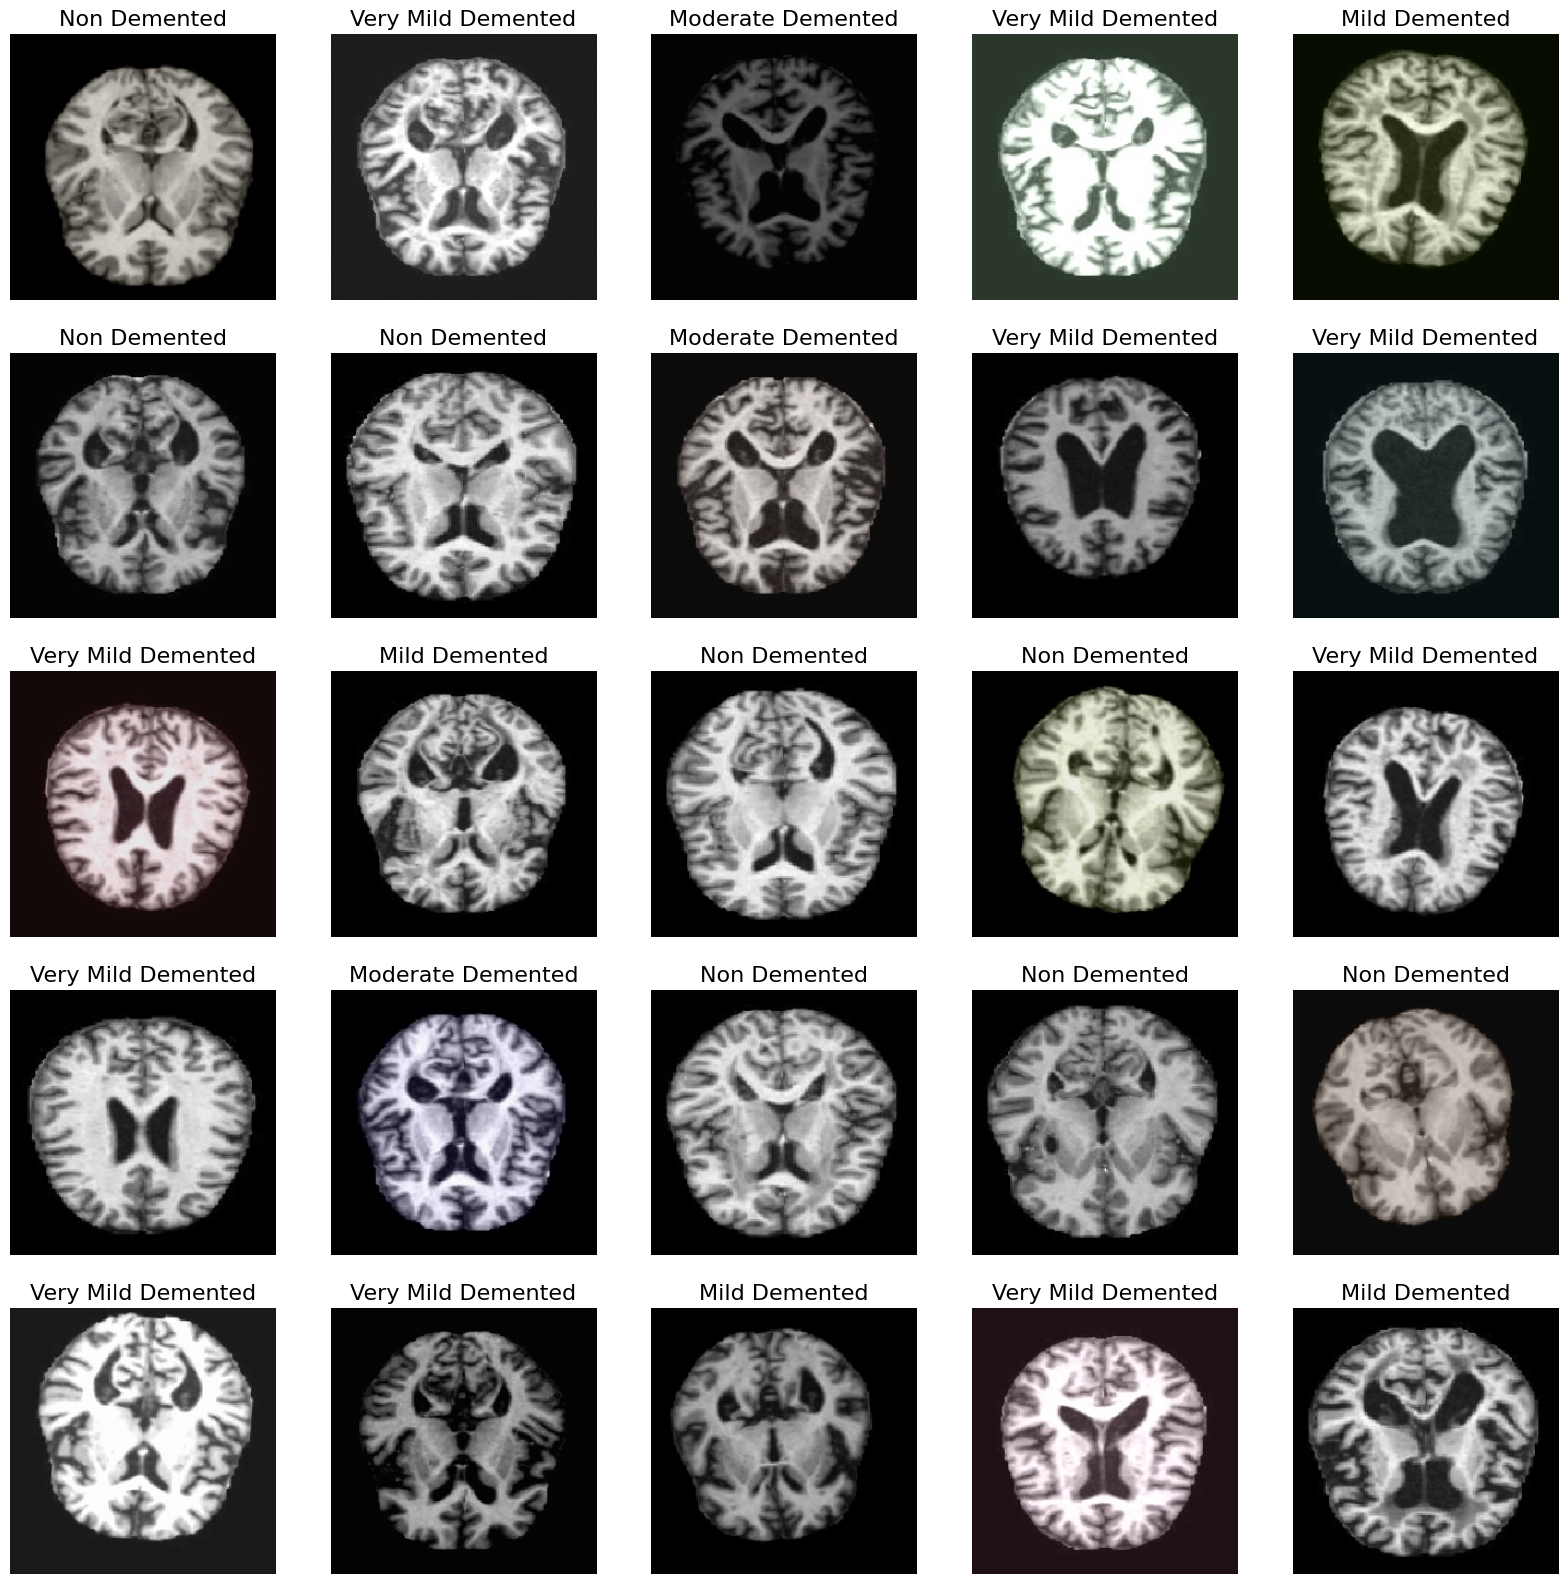

In [ ]:
show_brain_images(train)

## Initialization of the EfficientNetB7 base model

In [ ]:
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import  EfficientNetB7

img_shape=(244,244,3)
base_model =  EfficientNetB7(
    include_top= False,
    weights= "imagenet",
    input_shape= img_shape,
    pooling= 'max'
)

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


In [ ]:
base_model.trainable = True

# Flag to start fine-tuning
set_trainable = False

# Unfreeze layers from a specific point onwards
for layer in base_model.layers:
    if layer.name == 'block6a_expand_conv':  # You can change this layer to whichever layer you want to unfreeze
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
EfficientNetB7_model = Sequential([
    tf.keras.layers.InputLayer(input_shape=img_shape),
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(4, activation='softmax')
])

EfficientNetB7_model.compile(
    Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

EfficientNetB7_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)          │ (None, 2560)                │      64,097,687 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2560)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2560)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         327,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,426,011 (245.77 MB)

 Trainable params: 51,795,452 (197.58 MB)

 Non-trainable params: 12,630,559 (48.18 MB)

## Training

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True, verbose=1
)

history =  EfficientNetB7_model.fit(train, epochs=50, validation_data=val, callbacks=[early_stopping])

Epoch 1/50
595/595 ━━━━━━━━━━━━━━━━━━━━ 413s 502ms/step - accuracy: 0.3007 - loss: 1.5768 - val_accuracy: 0.4834 - val_loss: 1.1783
Epoch 2/50
595/595 ━━━━━━━━━━━━━━━━━━━━ 218s 366ms/step - accuracy: 0.4829 - loss: 1.1148 - val_accuracy: 0.5748 - val_loss: 0.9054
Epoch 3/50
595/595 ━━━━━━━━━━━━━━━━━━━━ 218s 365ms/step - accuracy: 0.5727 - loss: 0.9095 - val_accuracy: 0.6574 - val_loss: 0.7280
Epoch 4/50
595/595 ━━━━━━━━━━━━━━━━━━━━ 218s 365ms/step - accuracy: 0.6079 - loss: 0.8407 - val_accuracy: 0.6299 - val_loss: 0.7518
Epoch 5/50
595/595 ━━━━━━━━━━━━━━━━━━━━ 218s 366ms/step - accuracy: 0.6451 - loss: 0.7598 - val_accuracy: 0.7131 - val_loss: 0.6814
Epoch 6/50
595/595 ━━━━━━━━━━━━━━━━━━━━ 218s 366ms/step - accuracy: 0.6762 - loss: 0.7084 - val_accuracy: 0.7596 - val_loss: 0.5442
Epoch 7/50
595/595 ━━━━━━━━━━━━━━━━━━━━ 218s 365ms/step - accuracy: 0.7209 - loss: 0.6314 - val_accuracy: 0.7587 - val_loss: 0.5393
Epoch 8/50
595/595 ━━━━━━━━━━━━━━━━━━━━ 218s 365ms/step - accuracy: 0.7562 -

## Exploitation of training results

In [ ]:
train_loss, train_accuracy =  EfficientNetB7_model.evaluate(train)
print(f'\nTrain loss: {train_loss:.2f}')
print(f'Train Accuracy: {train_accuracy*100:.2f} %')

val_loss, val_accuracy =  EfficientNetB7_model.evaluate(val)
print(f'\nvalidation loss: {val_loss:.2f}')
print(f'Validation Accuracy: {val_accuracy*100:.2f} %')

test_loss, test_accuracy =  EfficientNetB7_model.evaluate(test)
print(f'\ntest loss: {test_loss:.2f}')
print(f'test Accuracy: {test_accuracy*100:.2f} %')

595/595 ━━━━━━━━━━━━━━━━━━━━ 110s 184ms/step - accuracy: 0.9964 - loss: 0.0125

Train loss: 0.01
Train Accuracy: 99.59 %
149/149 ━━━━━━━━━━━━━━━━━━━━ 27s 184ms/step - accuracy: 0.9666 - loss: 0.1034

validation loss: 0.10
Validation Accuracy: 96.49 %
319/319 ━━━━━━━━━━━━━━━━━━━━ 89s 280ms/step - accuracy: 0.9633 - loss: 0.1115

test loss: 0.11
test Accuracy: 96.44 %


In [ ]:
result = EfficientNetB7_model.evaluate(test, verbose=1)
print(result)

319/319 ━━━━━━━━━━━━━━━━━━━━ 59s 184ms/step - accuracy: 0.9633 - loss: 0.1115
[0.11269567906856537, 0.9643977880477905]


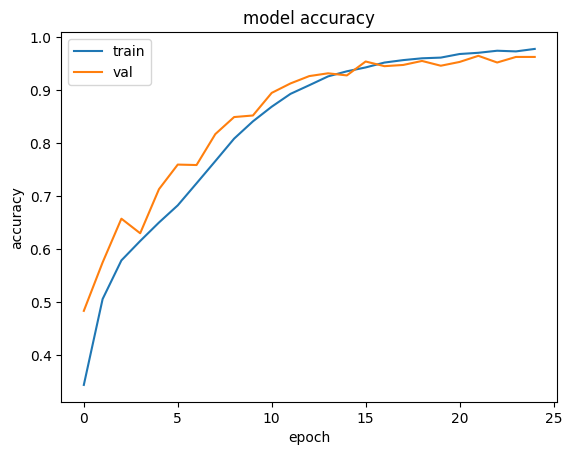

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

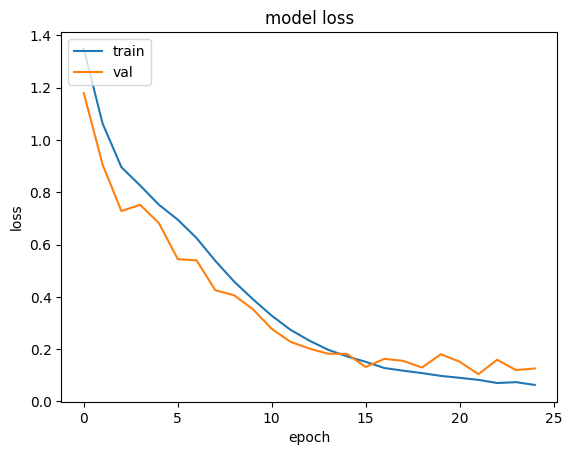

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Output

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

test_hat =  EfficientNetB7_model.predict(test)
test_hat = np.argmax(test_hat, axis=1)

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred_report = [labels[k] for k in test_hat]

y_test = test_images.labels
print(classification_report(y_test, pred_report))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred_report)*100))

319/319 ━━━━━━━━━━━━━━━━━━━━ 81s 214ms/step
                   precision    recall  f1-score   support

    Mild Demented       0.97      0.98      0.97      2688
Moderate Demented       0.99      1.00      1.00      1940
     Non Demented       0.95      0.95      0.95      2880
Very MildDemented       0.95      0.94      0.95      2688

         accuracy                           0.96     10196
        macro avg       0.97      0.97      0.97     10196
     weighted avg       0.96      0.96      0.96     10196

Accuracy of the Model: 96.4%


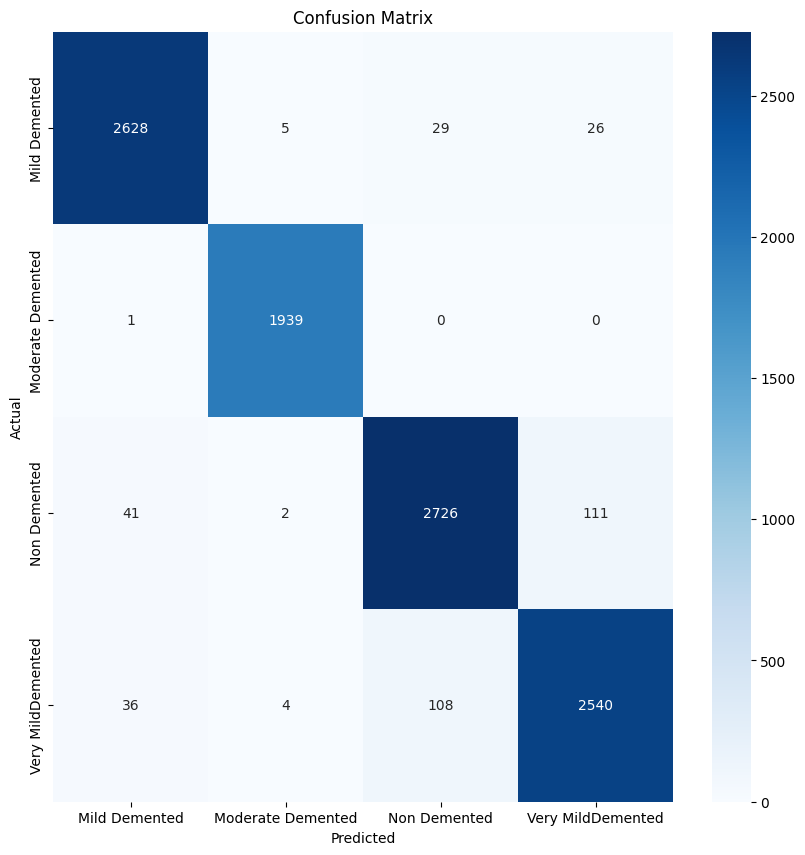

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the class labels
class_labels = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very MildDemented']

# Calculate the confusion matrix
cm = confusion_matrix(y_test, pred_report)

# Create a figure and plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

# Set tick labels and axis labels
plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Set the title
plt.title("Confusion Matrix")

# Show the plot
plt.show()